In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.tri as tri
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.colors import Normalize
%matplotlib inline

# 0. Functions

In [3]:
def getstats(db):
    stat = {}
    for unc in uncs:
        stat['unc' + str(unc)] = stats.describe(db['LLunc'+str(unc)])
        print('{}% Unc Stats: {} \n'.format(unc*100, stat['unc'+str(unc)]))
    return stat

In [31]:
def scatterme(g_or_b, XYZ, title, zname, vmax, zmax, xlims, ylims):
    if g_or_b == 'g':
        xtr = g['Burnup']
        ytr = g['CoolingTime']
        title = title + ' Good Prediction'
    else:
        xtr = b['Burnup']
        ytr = b['CoolingTime']
        title = title + ' Bad Prediction'
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    ax.set_title(title, fontsize=20, pad=15)
    ax.set_xlabel('Burnup [MWd/MTHM]', fontsize=20, labelpad=15)
    ax.set_ylabel('Cooling Time [days]', fontsize=20, labelpad=15)
    ax.set_xlim(xlims[g_or_b][0], xlims[g_or_b][1])
    ax.set_ylim(ylims[g_or_b][0], ylims[g_or_b][1])
    
    x = XYZ['Burnup']
    y = XYZ['CoolingTime']
    z = XYZ[zname] / zmax
    xerr = np.abs(x - xtr.values)
    scatter = ax.scatter(x, y, s=1000*z, c=xerr, vmin=0, vmax=vmax, cmap='viridis', alpha=0.5)
    
    handles, labels = scatter.legend_elements(prop='sizes', alpha=0.5)
    ax.legend(handles, labels, loc='upper left', title='Normalized Likelihood')
    cbar = fig.colorbar(scatter)
    cbar.ax.set_ylabel('Absolute Burnup Error', size=20, labelpad=15)
    cbar.ax.tick_params(labelsize=14)
    
    imax = XYZ[zname].idxmax()
    xpr = XYZ['Burnup'].iloc[imax]
    ypr = XYZ['CoolingTime'].iloc[imax]
    plt.plot([xpr], [ypr], marker='o', markersize=4, color="black")
    ax.annotate('Best Prediction', (xpr, ypr), weight='bold', xytext=(0, 7), textcoords='offset points')
    # Ground Truth can only contain predicted Cooling Time
    plt.plot([xtr], [ypr], marker='s', markersize=4, color="black")
    ax.annotate('Burnup Ground Truth', (xtr, ypr), weight='bold', xytext=(-100, -15), textcoords='offset points')
    ax.tick_params(labelsize=14)
    
    plt.tight_layout()
    plt.show()
    plt.clf()
    
    #tosave = '../plots/full_ll' + ****** + '.png'
    #fig.savefig(tosave, bbox_inches='tight', transparent=True)

# 1. Retreive LL calc results

## (a) LL calcs for uncertainty = 5%, 10%, 15%, 20%

In [4]:
lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']
nonlbls = ['AvgPowerDensity', 'ModDensity', 'UiWeight']

In [5]:
results = '~/sims_n_results/final_sims_nov2020/mll/full_ll/'

uncs = [0.05, 0.1, 0.15, 0.2]
job_dirs = ['Job' + str(i) + '_unc' + str(unc) for i, unc in enumerate(uncs)]
ll = {}
for i, unc_job in enumerate(job_dirs):
    csv = unc_job + '/' + unc_job + '.csv'
    if i == 0:
        ll['good'] = pd.read_csv(results + 'sfco_good/' + csv).drop(columns=['Unnamed: 0', 'Unnamed: 0.1']).rename(columns={'LL':'LLunc'+str(uncs[i])})
        ll['bad'] = pd.read_csv(results + 'sfco_bad/' + csv).drop(columns=['Unnamed: 0', 'Unnamed: 0.1']).rename(columns={'LL':'LLunc'+str(uncs[i])})
    else:
        ll['good']['LLunc'+str(uncs[i])] = pd.read_csv(results + 'sfco_good/' + csv)['LL']
        ll['bad']['LLunc'+str(uncs[i])] = pd.read_csv(results + 'sfco_bad/' + csv)['LL']

In [10]:
ll['bad'].columns

Index(['AvgPowerDensity', 'Burnup', 'CoolingTime', 'Enrichment', 'ModDensity',
       'OrigenReactor', 'ReactorType', 'UiWeight', 'am241', 'am242m', 'am243',
       'cm242', 'cm244', 'cs134', 'cs137', 'eu154', 'nd143', 'nd144', 'nd145',
       'nd146', 'nd148', 'nd150', 'np237', 'pu238', 'pu239', 'pu240', 'pu241',
       'pu242', 'sm147', 'sm149', 'sm150', 'sm151', 'sm152', 'u234', 'u235',
       'u236', 'u238', 'LLunc0.05', 'LLunc0.1', 'LLunc0.15', 'LLunc0.2'],
      dtype='object')

## (b) Test samples for LL calcs

In [7]:
g = pd.read_pickle('../mll_calc/htc_files/sfco_good.pkl')
g

,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,am241,am242m,am243,cm242,cm244,...,pu242,sm147,sm149,sm150,sm151,sm152,u234,u235,u236,u238
TMI-1|NJ070G|O13|S7,22800.0,0.0,4.66,Three Mile Island-1_PWR,pwr,0.1626,0.000316,0.01607,0.000007,0.002462,...,0.1447,0.1748,0.003975,0.1936,0.01269,0.0796,0.343,23.78,4.219,0.0


In [8]:
b = pd.read_pickle('../mll_calc/htc_files/sfco_bad.pkl')
b

,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,am241,am242m,am243,cm242,cm244,...,pu242,sm147,sm149,sm150,sm151,sm152,u234,u235,u236,u238
MON-1|MTB099|F6|S4,44100.0,0.0,2.87,Monticello-1_BWR,bwr,0.0,0.0,0.0,0.02877,0.0,...,0.878,0.0,0.0,0.0,0.0,0.0,0.1021,4.269,4.225,933.7


In [9]:
# for reference
to_print = ['sim_idx', 'pred_idx', 'MaxLogLL',
            'pred_AvgPowerDensity', 'pred_ModDensity', 'pred_CoolingTime',
            'ReactorType', 'pred_ReactorType', 'ReactorType_Score', 
            'Enrichment', 'pred_Enrichment', 'Relative_Enrichment_Error', 
            'Burnup', 'pred_Burnup', 'Relative_Burnup_Error',
            'OrigenReactor', 'pred_OrigenReactor']

pred_g = pd.read_pickle('sfco_pred_good.pkl')
pred_b = pd.read_pickle('sfco_pred_bad.pkl')

#gidx = 470037
#bidx = 230410
pred_g#[to_print]

,sim_idx,pred_idx,MaxLogLL,pred_AvgPowerDensity,pred_ModDensity,pred_CoolingTime,ReactorType,pred_ReactorType,ReactorType_Score,Enrichment,pred_Enrichment,Relative_Enrichment_Error,Burnup,pred_Burnup,Relative_Burnup_Error,OrigenReactor,pred_OrigenReactor
328,TMI-1|NJ070G|O13|S7,446536,28.662774,35.0,0.71,1521.070654,pwr,pwr,True,4.66,4.76,0.021459,22800.0,23170.26,0.016239,Three Mile Island-1_PWR,w17x17


In [10]:
pred_b#[to_print]

,sim_idx,pred_idx,MaxLogLL,pred_AvgPowerDensity,pred_ModDensity,pred_CoolingTime,ReactorType,pred_ReactorType,ReactorType_Score,Enrichment,pred_Enrichment,Relative_Enrichment_Error,Burnup,pred_Burnup,Relative_Burnup_Error,OrigenReactor,pred_OrigenReactor
168,MON-1|MTB099|F6|S4,510185,-454.632313,25.0,0.71,129.30773,bwr,pwr,False,2.87,4.36,0.519164,44100.0,63663.56,0.443618,Monticello-1_BWR,vver1000


In [11]:
idx05 = ll['bad']['LLunc0.05'].idxmax()
idx10 = ll['bad']['LLunc0.1'].idxmax()
idx15 = ll['bad']['LLunc0.15'].idxmax()
idx20 = ll['bad']['LLunc0.2'].idxmax()
#print(ll['bad'].iloc[452471], '\n') # Should correspond to LL of 2.3e-30
print(idx05, '\n')#, ll['bad'].iloc[idx05], '\n')
print(idx10, '\n')#, ll['bad'].iloc[idx10], '\n')
print(idx15, '\n')#, ll['bad'].iloc[idx15], '\n')
print(idx20, '\n')#, ll['bad'].iloc[idx20], '\n')

510185 

510185 

508684 

508684 



# 2. Likelihood for 4 simulated uncertainty values
This is std/scale in logpdf function

In [12]:
stat_good = getstats(ll['good'])

5.0% Unc Stats: DescribeResult(nobs=528480, minmax=(0.0, 2805981316681.129), mean=5311310.9011501875, variance=1.4898448133816457e+19, skewness=726.9641346036702, kurtosis=528474.901981251) 

10.0% Unc Stats: DescribeResult(nobs=528480, minmax=(0.0, 9.030962517004042e+31), mean=2.2293594840379547e+26, variance=1.59223002002745e+58, skewness=696.6084623157551, kurtosis=496764.0582415771) 

15.0% Unc Stats: DescribeResult(nobs=528480, minmax=(0.0, 2.74974631518786e+32), mean=1.376986188114835e+27, variance=2.075960320497839e+59, skewness=489.14938336891356, kurtosis=270043.1799664404) 

20.0% Unc Stats: DescribeResult(nobs=528480, minmax=(0.0, 9.174057133715576e+30), mean=8.739176340422352e+25, variance=3.786505936329726e+56, skewness=347.2629294346601, kurtosis=137267.29327099439) 



In [13]:
stat_bad = getstats(ll['bad'])

5.0% Unc Stats: DescribeResult(nobs=528480, minmax=(0.0, 3.594970826392064e-198), mean=1.721069944849253e-203, variance=0.0, skewness=0.0, kurtosis=-3.0) 

10.0% Unc Stats: DescribeResult(nobs=528480, minmax=(0.0, 3.257008260850495e-49), mean=7.581593688931015e-54, variance=9.853255154048116e-103, skewness=199.3484415876218, kurtosis=48470.7880703966) 

15.0% Unc Stats: DescribeResult(nobs=528480, minmax=(0.0, 1.1180654682510556e-22), mean=7.5989956005088e-27, variance=3.6043505084319144e-49, skewness=112.79146650674242, kurtosis=15044.520383195888) 

20.0% Unc Stats: DescribeResult(nobs=528480, minmax=(0.0, 7.422896313100659e-14), mean=8.02051252981228e-18, variance=2.218253606432844e-31, skewness=86.01233584490323, kurtosis=8710.90565152975) 



In [29]:
xlims = {'g' : [20000, 26000],
         'b' : [35000, 68000]
         }
ylims = {'g' : [500, 2500],
         'b' : [0, 300]
         }

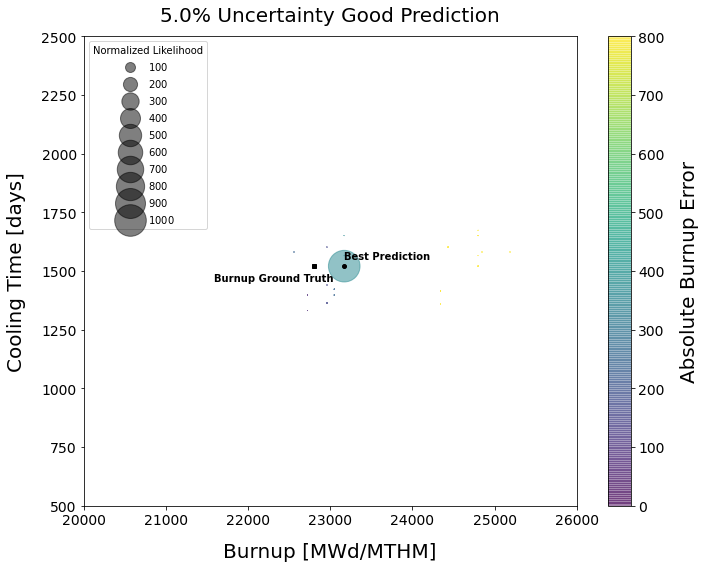

<Figure size 432x288 with 0 Axes>

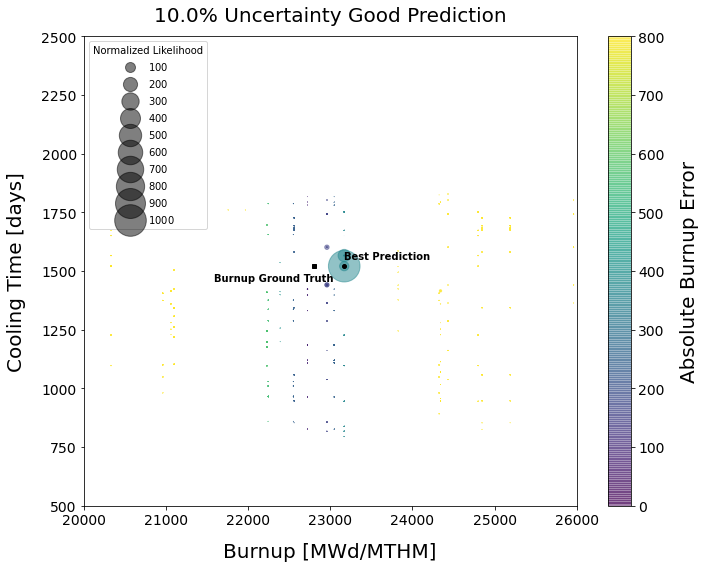

<Figure size 432x288 with 0 Axes>

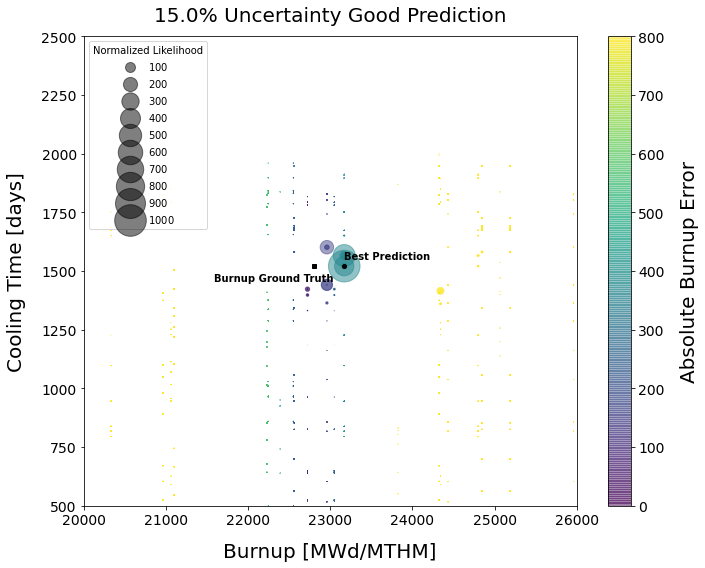

<Figure size 432x288 with 0 Axes>

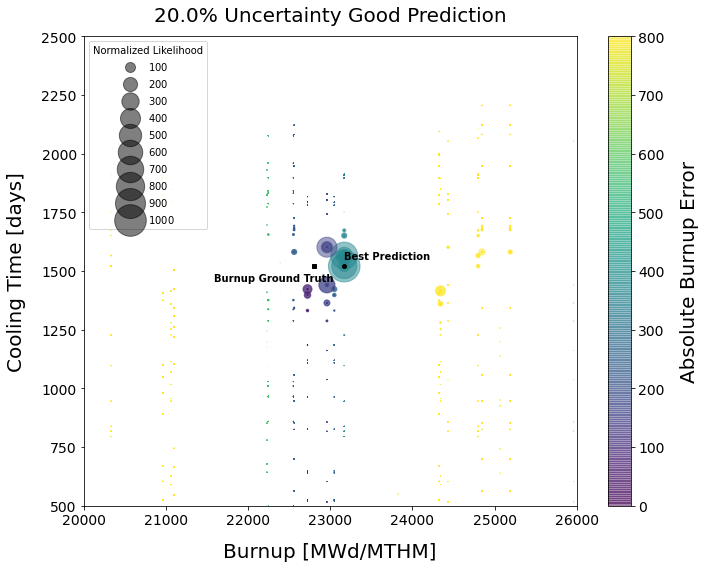

<Figure size 432x288 with 0 Axes>

In [34]:
for i, unc in enumerate(uncs[0:4]):
    zname = 'LLunc'+str(unc)
    title = str(unc*100) + '% Uncertainty'
    zmax = stat_good['unc' + str(unc)].minmax[1]
    scatterme('g', ll['good'][['Burnup', 'CoolingTime', zname]], title, zname, 800, zmax, xlims, ylims)

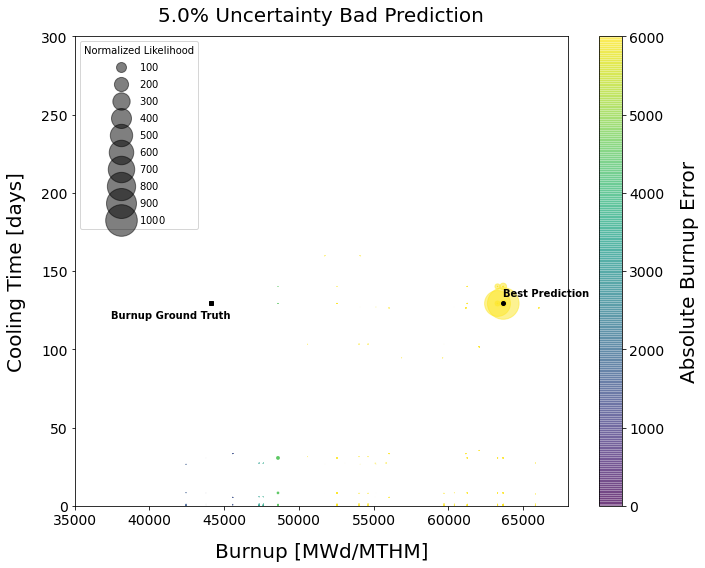

<Figure size 432x288 with 0 Axes>

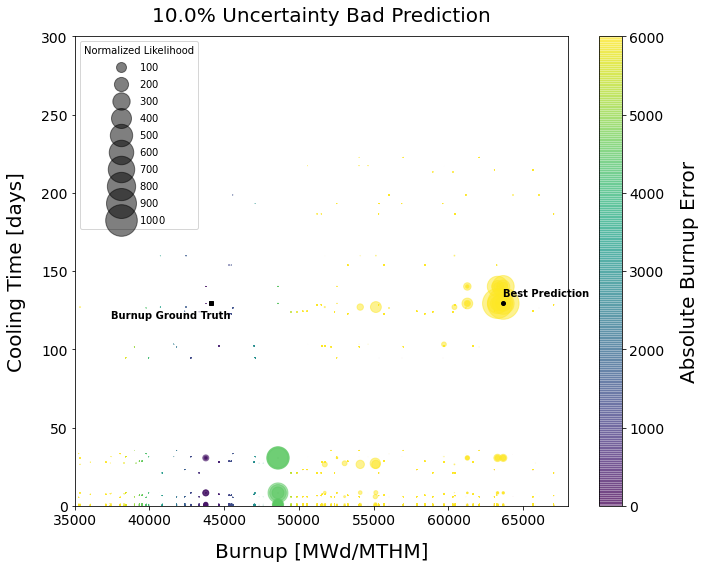

<Figure size 432x288 with 0 Axes>

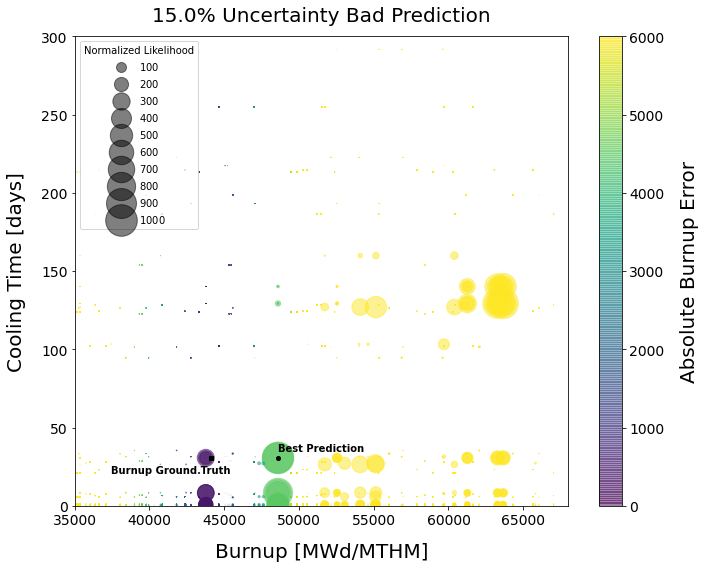

<Figure size 432x288 with 0 Axes>

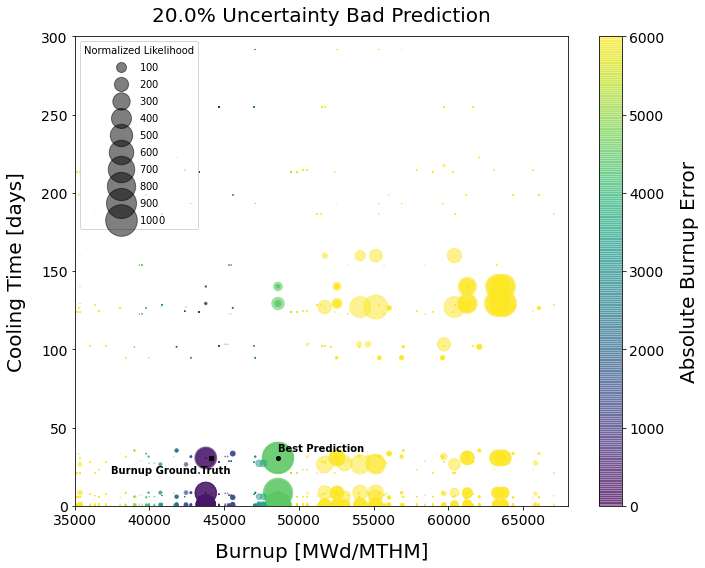

<Figure size 432x288 with 0 Axes>

In [33]:
for i, unc in enumerate(uncs[0:4]):
    zname = 'LLunc'+str(unc)
    title = str(unc*100) + '% Uncertainty'
    zmax = stat_bad['unc' + str(unc)].minmax[1]
    scatterme('b', ll['bad'][['Burnup', 'CoolingTime', zname]], title, zname, 6000, zmax, xlims, ylims)

# 16 Dec 2020 end of update

## _______________________________
### (Unlikely to use heatmaps moving forward)

In [4]:
def plotme(g_or_b, XYZ, title, zname, vmin, vmax):
    fig = plt.figure(figsize=(10, 8))
    #cmap = sns.cubehelix_palette(6, as_cmap=True)
    norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
    ax = fig.add_subplot(111)
    ax.set_title(title, fontsize=20, pad=15)
    ax.set_xlabel('Burnup [MWd/MTHM]', fontsize=20, labelpad=15)
    ax.set_ylabel('Cooling Time [days]', fontsize=20, labelpad=15)
    
    x = XYZ['Burnup']
    y = XYZ['CoolingTime']
    triang_unref = tri.Triangulation(x, y)
    z_unref = XYZ[zname]
    
    refiner = tri.UniformTriRefiner(triang_unref)
    triang, z = refiner.refine_field(z_unref)
    
    surf = ax.tripcolor(triang, z, norm=norm, cmap=cm.viridis, shading='gouraud')
    #surf = ax.tricontourf(triang, z, norm=norm, cmap=cm.viridis)
    if g_or_b == 'g':
        xtr = sims.iloc[0]['Burnup']
        ytr = 3000#sims.iloc[0]['CoolingTime']
        ax.set_xlim(24000, 29000)
        ax.set_ylim(1700, 4100)
    else:
        xtr = 9730#sims.iloc[1]['Burnup']
        ytr = 7#sims.iloc[1]['CoolingTime']
        ax.set_xlim(7000, 25000)
        ax.set_ylim(0, 400)
    xpr = XYZ['Burnup'].iloc[XYZ[zname].idxmax()]
    ypr = XYZ['CoolingTime'].iloc[XYZ[zname].idxmax()]
    plt.plot([xpr], [ypr], marker='o', markersize=4, color="white")
    ax.annotate('Best Prediction', (xpr, ypr), weight='bold', xytext=(0, 5), textcoords='offset points')
    plt.plot([xtr], [ytr], marker='s', markersize=4, color="white")
    ax.annotate('Ground Truth', (xtr, ytr), weight='bold', xytext=(5, 2), textcoords='offset points')
    ax.tick_params(labelsize=14)
    
    cbar = fig.colorbar(surf)
    cbar.ax.set_ylabel('Likelihood', size=20, labelpad=15)
    cbar.ax.tick_params(labelsize=14)
    
    plt.tight_layout()
    plt.show()
    plt.clf()
    #fig.savefig('../plots/llsurf_***.png', bbox_inches='tight', transparent=True)

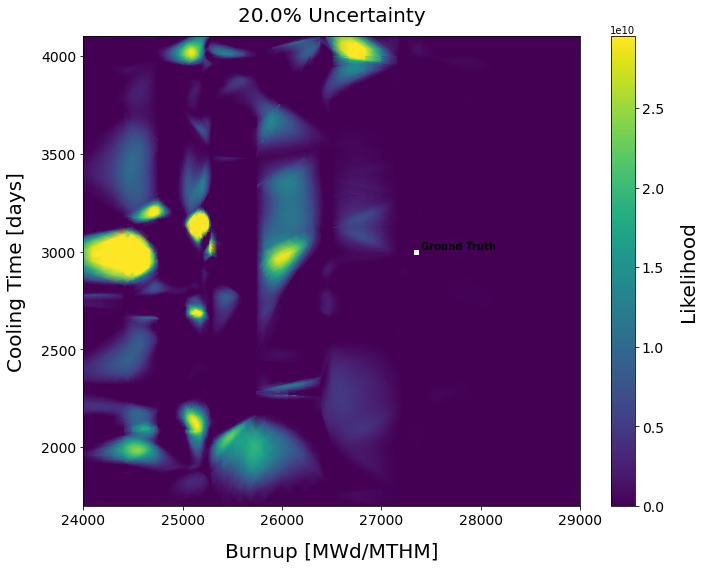

<Figure size 432x288 with 0 Axes>

In [13]:
unc = 0.2
zname = 'LLunc'+str(unc)
title = str(unc*100) + '% Uncertainty'
vmin = 0
vmax = stat_good['unc' + str(unc)].minmax[1]
plotme('g', ll['good'][['Burnup', 'CoolingTime', zname]], title, zname, vmin, vmax)

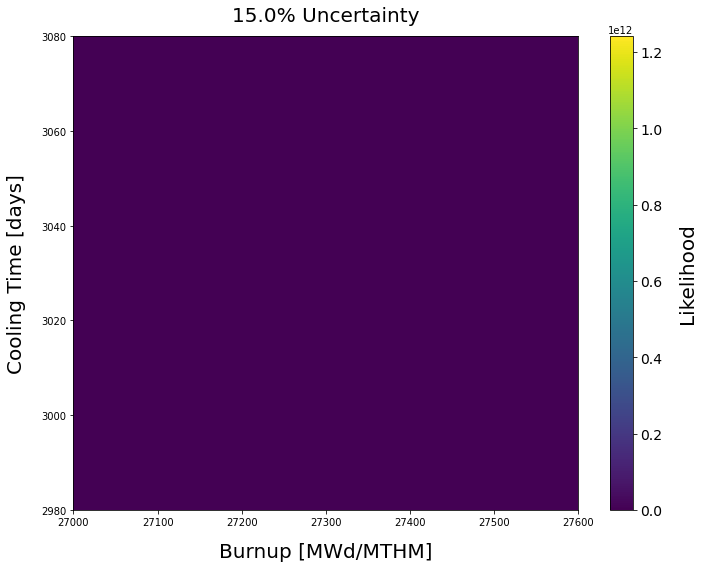

<Figure size 432x288 with 0 Axes>

In [38]:
for i, unc in enumerate(uncs[2:3]):
    zname = 'LLunc'+str(unc)
    title = str(unc*100) + '% Uncertainty'
    vmin = 0
    #vmin = ll['good'][zname].describe().mean
    vmax = stat_good['unc' + str(unc)].minmax[1]
    plotme('g', ll['good'][['Burnup', 'CoolingTime', zname]], title, zname, vmin, vmax)
    #plotme('g', test[['Burnup', 'CoolingTime', zname]], title, zname, vmin, vmax)

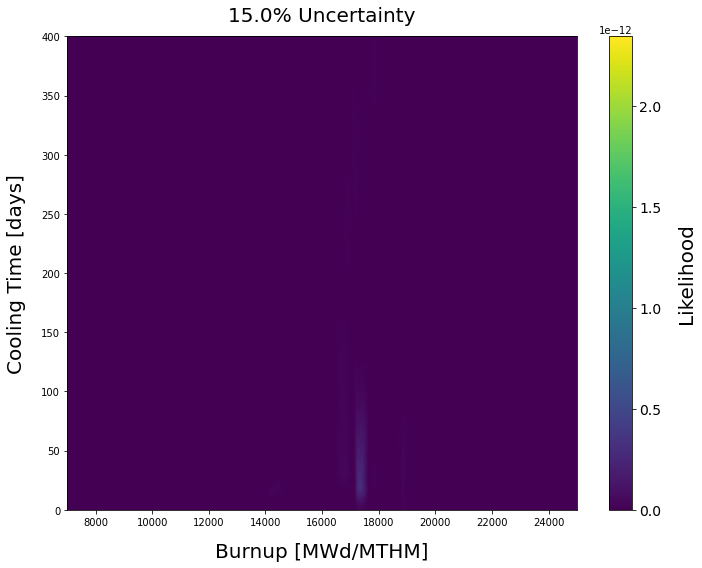

<Figure size 432x288 with 0 Axes>

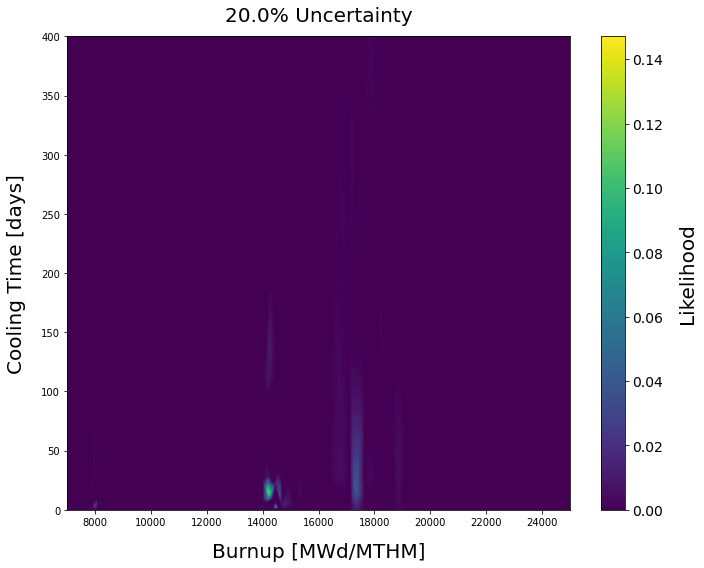

<Figure size 432x288 with 0 Axes>

In [20]:
for i, unc in enumerate(uncs[2:4]):
    zname = 'LLunc'+str(unc)
    title = str(unc*100) + '% Uncertainty'
    #vmin = stat_bad['unc' + str(unc)].mean
    vmin = 0
    vmax = stat_bad['unc' + str(unc)].minmax[1]
    plotme('b', ll['bad'][['Burnup', 'CoolingTime', zname]], title, zname, vmin, vmax)

# 4 Oct 2020 end of update

## _______________________________

# 3. Get LL Pred Results

In [102]:
ll1 = 'LogLikelihood_0.05'
ll2 = 'LogLikelihood_0.1'
ll3 = 'LogLikelihood_0.15'
ll4 = 'LogLikelihood_0.2'
lu1 = 'LLUncertainty_0.05'
lu2 = 'LLUncertainty_0.1'
lu3 = 'LLUncertainty_0.15'
lu4 = 'LLUncertainty_0.2'
lls = [ll1, ll2, ll3, ll4]
lus = [lu1, lu2, lu3, lu4]
uncs = ['5% Uncertainty', '10% Uncertainty', '15% Uncertainty', '20% Uncertainty']

In [103]:
fullXY.head()

,Unnamed: 0,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,...,LLUncertainty_0.05,Likelihood0.1,LogLikelihood_0.1,LLUncertainty_0.1,Likelihood0.15,LogLikelihood_0.15,LLUncertainty_0.15,Likelihood0.2,LogLikelihood_0.2,LLUncertainty_0.2
0,1,2006.54,0.000839,0.53,ce14x14,pwr,0.000593,0.6109,0.5142,0.002411,...,2.507794e+10,0.0,-6.276547e+10,1.253897e+10,0.0,-2.789577e+10,8.359314e+09,0.0,-1.569137e+10,6.269485e+09
1,2,2006.54,0.592485,0.53,ce14x14,pwr,0.000600,0.6114,0.5204,0.002411,...,2.507794e+10,0.0,-6.276537e+10,1.253897e+10,0.0,-2.789572e+10,8.359314e+09,0.0,-1.569134e+10,6.269485e+09
2,3,2006.54,1.109213,0.53,ce14x14,pwr,0.000607,0.6114,0.5256,0.002410,...,2.507794e+10,0.0,-6.276530e+10,1.253897e+10,0.0,-2.789569e+10,8.359314e+09,0.0,-1.569132e+10,6.269485e+09
3,4,2006.54,8.460400,0.53,ce14x14,pwr,0.000681,0.6114,0.5759,0.002394,...,2.507794e+10,0.0,-6.276469e+10,1.253897e+10,0.0,-2.789542e+10,8.359314e+09,0.0,-1.569117e+10,6.269485e+09
4,5,2006.54,38.415629,0.53,ce14x14,pwr,0.000806,0.6114,0.6069,0.002329,...,2.507794e+10,0.0,-6.276476e+10,1.253897e+10,0.0,-2.789545e+10,8.359314e+09,0.0,-1.569119e+10,6.269486e+09


## Reactor Prediction

In [104]:
data = {}
idx = {}
for ll, lu in zip(lls, lus):
    max_pwr = fullXY[ll].loc[fullXY['ReactorType'] == 'pwr'].max()
    idx_pwr = fullXY[ll].loc[fullXY['ReactorType'] == 'pwr'].idxmax()
    unc_pwr = float(fullXY[lu].loc[fullXY.index == idx_pwr])
    max_bwr = fullXY[ll].loc[fullXY['ReactorType'] == 'bwr'].max()
    idx_bwr = fullXY[ll].loc[fullXY['ReactorType'] == 'bwr'].idxmax()
    unc_bwr = float(fullXY[lu].loc[fullXY.index == idx_bwr])
    max_phwr = fullXY[ll].loc[fullXY['ReactorType'] == 'phwr'].max()
    idx_phwr = fullXY[ll].loc[fullXY['ReactorType'] == 'phwr'].idxmax()
    unc_phwr = float(fullXY[lu].loc[fullXY.index == idx_phwr])
    data[ll] = [max_pwr, max_bwr, max_phwr]
    data[lu] = [unc_pwr, unc_bwr, unc_phwr]
    idx[ll] = [idx_pwr, idx_bwr, idx_phwr]
rxtr = pd.DataFrame(data, columns=[ll1, lu1, ll2, lu2, ll3, lu3, ll4, lu4], index=['pwr', 'bwr', 'phwr'])
rxtr

,LogLikelihood_0.05,LLUncertainty_0.05,LogLikelihood_0.1,LLUncertainty_0.1,LogLikelihood_0.15,LLUncertainty_0.15,LogLikelihood_0.2,LLUncertainty_0.2
pwr,18.967565,3.254686,10.520009,1.627343,5.024011,1.508366,0.943795,1.131275
bwr,2.344970,8.902489,6.566396,4.451245,3.208129,3.008143,-0.083764,2.718742
phwr,-451595.105989,37524.646638,-112875.317334,18762.323319,-50153.587113,12508.215546,-28203.168076,9381.161659


In [105]:
idx

{'LogLikelihood_0.05': [2831, 21324, 24672],
 'LogLikelihood_0.1': [2831, 21324, 24672],
 'LogLikelihood_0.15': [3893, 21315, 24672],
 'LogLikelihood_0.2': [3893, 14034, 24672]}

In [106]:
for ll in lls:
    print(ll)
    for i, index in enumerate(idx[ll]):
        print(fullXY.loc[fullXY.index == idx[ll][i], ['ReactorType', 'Burnup', 'CoolingTime']])

LogLikelihood_0.05
     ReactorType    Burnup  CoolingTime
2831         pwr  40412.05   392.313045
      ReactorType    Burnup  CoolingTime
21324         bwr  37521.68    34.458875
      ReactorType    Burnup  CoolingTime
24672        phwr  13678.58     5.662128
LogLikelihood_0.1
     ReactorType    Burnup  CoolingTime
2831         pwr  40412.05   392.313045
      ReactorType    Burnup  CoolingTime
21324         bwr  37521.68    34.458875
      ReactorType    Burnup  CoolingTime
24672        phwr  13678.58     5.662128
LogLikelihood_0.15
     ReactorType    Burnup  CoolingTime
3893         pwr  39013.38   343.237299
      ReactorType    Burnup  CoolingTime
21315         bwr  37361.88    34.458875
      ReactorType    Burnup  CoolingTime
24672        phwr  13678.58     5.662128
LogLikelihood_0.2
     ReactorType    Burnup  CoolingTime
3893         pwr  39013.38   343.237299
      ReactorType    Burnup  CoolingTime
14034         bwr  36727.11    37.125682
      ReactorType    Burnup  Coo

In [71]:
max_tot = fullXY[ll1].max()
idx = fullXY[ll1].idxmax()
max_tot, idx

(68.62441895096356, 20912)

In [94]:
sim_idx = 13379
top_answer = fullXY.loc[fullXY.index == sim_idx, lbls]
top_answer

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
13379,bwr,2690.358732,2.88,2010.26,ge9x9-2


In [90]:
sim_idx = 10522
top_answer = XY.loc[XY.index == sim_idx, lbls]
top_answer

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
10522,bwr,2421.282899,2.89,2024.53,ge7x7-0


In [82]:
xy = pd.read_csv('likelihood_idx5010_15nucs_opusupdate-aug2019.csv')

In [83]:
xy.head()

,Unnamed: 0,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,...,LLUncertainty_0.05,Likelihood0.1,LogLikelihood_0.1,LLUncertainty_0.1,Likelihood0.15,LogLikelihood_0.15,LLUncertainty_0.15,Likelihood0.2,LogLikelihood_0.2,LLUncertainty_0.2
0,1,2006.54,0.000839,0.53,ce14x14,pwr,0.000593,0.6109,0.5142,0.002411,...,2.507794e+10,0.0,-6.276547e+10,1.253897e+10,0.0,-2.789577e+10,8.359314e+09,0.0,-1.569137e+10,6.269485e+09
1,2,2006.54,0.592485,0.53,ce14x14,pwr,0.000600,0.6114,0.5204,0.002411,...,2.507794e+10,0.0,-6.276537e+10,1.253897e+10,0.0,-2.789572e+10,8.359314e+09,0.0,-1.569134e+10,6.269485e+09
2,3,2006.54,1.109213,0.53,ce14x14,pwr,0.000607,0.6114,0.5256,0.002410,...,2.507794e+10,0.0,-6.276530e+10,1.253897e+10,0.0,-2.789569e+10,8.359314e+09,0.0,-1.569132e+10,6.269485e+09
3,4,2006.54,8.460400,0.53,ce14x14,pwr,0.000681,0.6114,0.5759,0.002394,...,2.507794e+10,0.0,-6.276469e+10,1.253897e+10,0.0,-2.789542e+10,8.359314e+09,0.0,-1.569117e+10,6.269485e+09
4,5,2006.54,38.415629,0.53,ce14x14,pwr,0.000806,0.6114,0.6069,0.002329,...,2.507794e+10,0.0,-6.276476e+10,1.253897e+10,0.0,-2.789545e+10,8.359314e+09,0.0,-1.569119e+10,6.269486e+09


In [85]:
max_tot = xy[ll1].max()
idx = xy[ll1].idxmax()
max_tot, idx

(18.967564797385485, 2831)

In [86]:
sim_idx = 2831
top_answer = xy.loc[xy.index == sim_idx, lbls]
top_answer

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
2831,pwr,392.313045,3.07,40412.05,w14x14
